In [4]:
import xarray as xr
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import natural_earth, Reader
import cartopy.io.shapereader as shpreader
import warnings
warnings.filterwarnings('ignore')

In [5]:
def convert_longitude(lon_array):
    """
    Convert longitude values from 0-360° format to -180 to +180° format.
    
    Parameters:
    lon_array : numpy.ndarray
        Input longitude array with values between 0 and 360 degrees
        
    Returns:
    numpy.ndarray
        Converted longitude array with values between -180 and +180 degrees
    """
    # Make a copy to avoid modifying the original array
    lon_converted = np.copy(lon_array)
    
    # Find values greater than 180° and subtract 360° from them
    lon_converted = np.where(lon_converted > 180, lon_converted - 360, lon_converted)
    
    return lon_converted

In [6]:
country_list = ['Senegal', 'Guinea', 'Côte dIvoire', 
                'Ghana', 'Togo', 'Benin', 'Nigeria', 'Cameroon']

## Climatology

In [7]:
xr.open_dataset('./data/sst.mnmean.nc')

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2048, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2024-08-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2024-09-04

In [11]:
sst_mn_mean = xr.open_dataset('./data/sst.mnmean.nc')
sst_mn_mean = sst_mn_mean.sel(time = slice('1990-01-01', '2021-12-01'))
sst_mn_mean.coords['lon']= np.where(sst_mn_mean.lon > 180, 
                                  sst_mn_mean.lon - 360, 
                                  sst_mn_mean.lon)

sst_mn_mean=sst_mn_mean.sortby('lon')
sst_mn_mean['sst']=sst_mn_mean.sst.roll(lon=int(180/2), roll_coords=True)

sst_mn_mean

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 384, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 -178.0 -176.0 -174.0 -172.0 ... 176.0 178.0 180.0
  * time       (time) datetime64[ns] 1990-01-01 1990-02-01 ... 2021-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2024-09-04

In [46]:
#sst_mn_mean = sst_mn_mean['sst'].sel(time = slice('1990-01-01', '2021-12-01'))
sst_climatology = sst_mn_mean.mean(dim='time')
sst_climatology

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 -178.0 -176.0 -174.0 -172.0 ... 176.0 178.0 180.0
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (nbnds) float64 9.969e+36 9.969e+36
    sst        (lat, lon) float32 -1.799 -1.799 -1.799 -1.799 ... nan nan nan

In [47]:
fig = go.Figure(data=go.Heatmap(
    z=sst_climatology['sst'],
    x=sst_climatology['lon'],
    y=sst_climatology['lat'],
    colorscale='viridis',
    colorbar=dict(
        title=dict(
            text='Sea Surface Temperature (°C)',
            side='right'
        )
    )
))
fig.update_layout(xaxis_title='Longitude', yaxis_title='Latitude', width = 900, height=700)
fig.show()

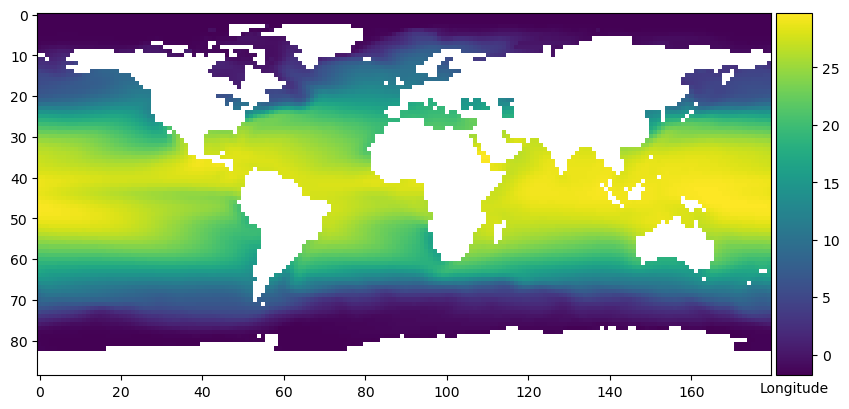

In [49]:
# Create the plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(10, 10))

# Display the image using plt.imshow
im = ax.imshow(sst_climatology['sst'].values)

# Create a divider for the existing axes to align the color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust size and padding as needed

plt.gca().set_xlabel('Longitude')

# Add the color bar to the new axes, ensuring it fits the image size
plt.colorbar(im, cax=cax)

# Show the plot
plt.show()

# Anomaly

In [50]:
sst_mn_mean

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 384, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 -178.0 -176.0 -174.0 -172.0 ... 176.0 178.0 180.0
  * time       (time) datetime64[ns] 1990-01-01 1990-02-01 ... 2021-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2024-09-04

In [52]:
# Calculate the year average
sst_yr_mean=sst_mn_mean.groupby('time.year').mean(dim='time')

#
climateology = sst_yr_mean.mean(dim='year')

# Calculate the anomaly
anomaly = sst_yr_mean - climateology

#anomaly

#test = anomaly.groupby('time.month').mean(dim='time')
anomaly

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, year: 32, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 -178.0 -176.0 -174.0 -172.0 ... 176.0 178.0 180.0
  * year       (year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (year, nbnds) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sst        (year, lat, lon) float32 -0.0007368 -0.0009013 ... nan nan

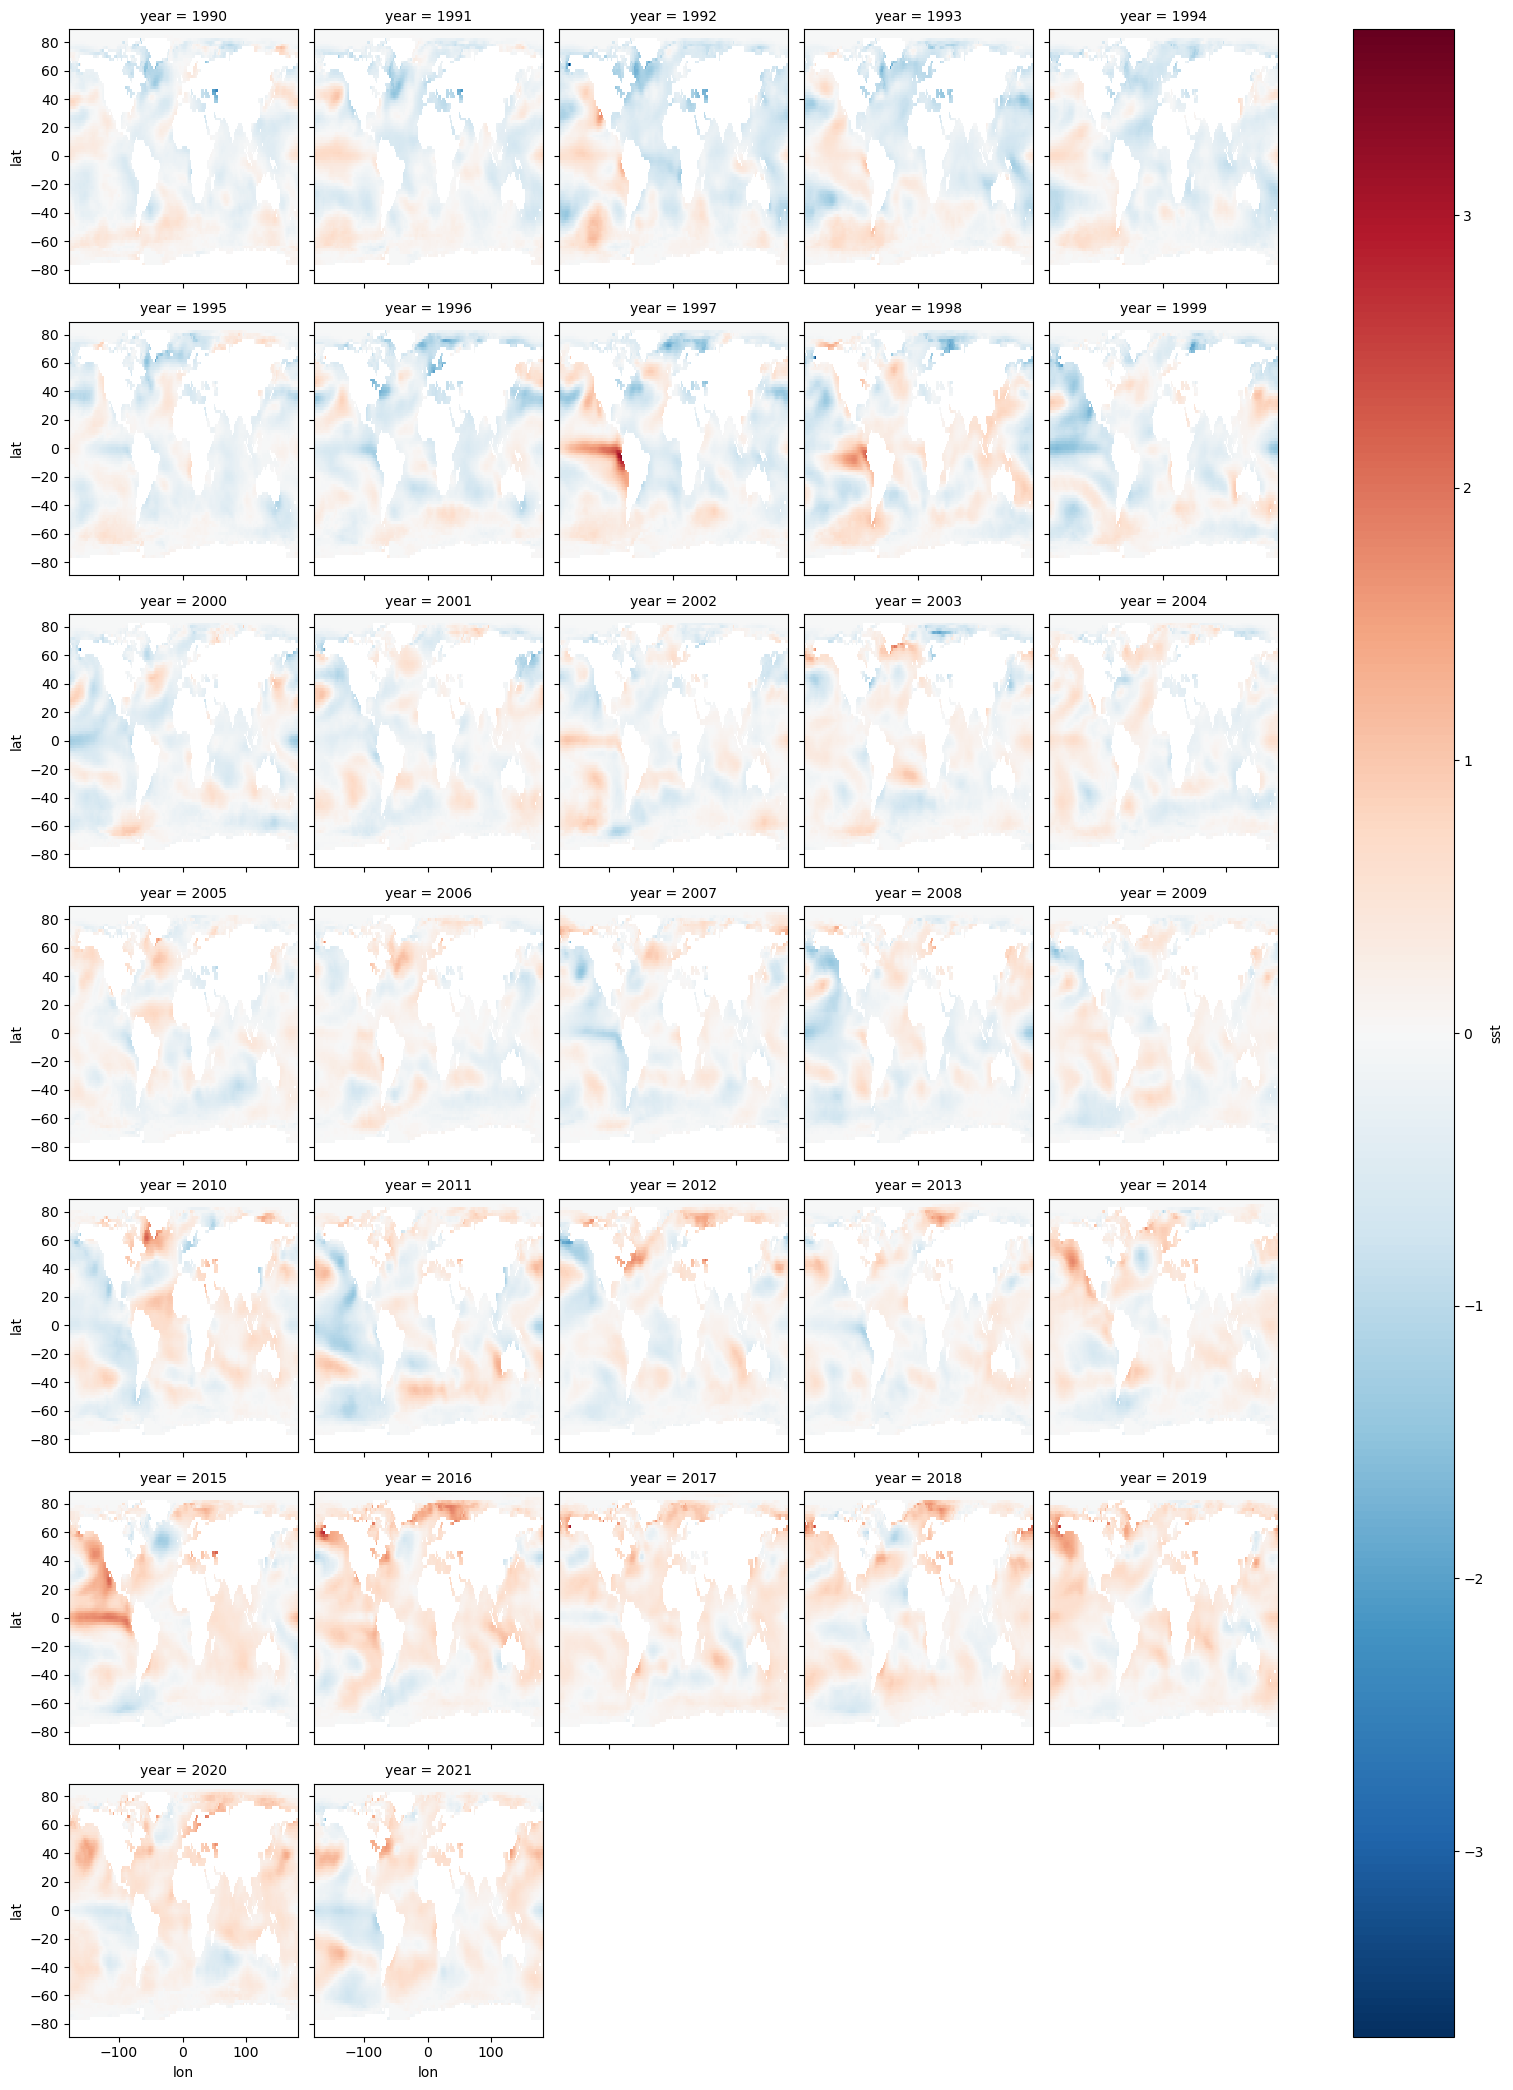

In [53]:
anomaly['sst'].plot(col='year', col_wrap = 5)

In [ ]:
px.imshow(climatology['sst'], x=lon, y=-lat)

In [60]:
anomaly = sst_yr_mean.groupby('year') - climatology
px.imshow(anomaly.mean(dim='year')['sst'], x=lon, y=-lat)

ValueError: incompatible dimensions for a grouped binary operation: the group variable 'year' is not a dimension on the other argument with dimensions Frozen({'lat': 89, 'lon': 180, 'nbnds': 2})

## Anomaly

In [46]:
sst_mn_mean_anomaly = xr.open_dataset('/Users/kris/GitHub/fall_2024_trp_proj/data/sst.mnmean.anomaly.nc')
#sst_mn_mean = sst_mn_mean.sel(year = slice('1990-01-01', '2021-12-01'))
#lat=sst_mn_mean['lat']
#lon=sst_mn_mean['lon']
sst_mn_mean_anomaly


<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 528)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-12-01
    month    (time) int64 ...
Data variables:
    sst      (time, lat, lon) float32 ...